<AxesSubplot:xlabel='Epochs', ylabel='Accuracy'>

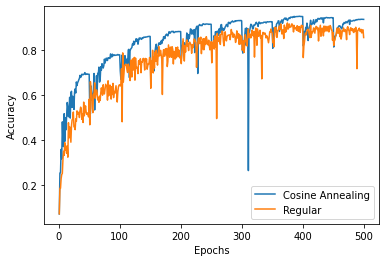

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def get_graph_data(path, columns_to_drop):
    raw_data = pd.read_csv(path)
    raw_data = raw_data.drop(columns_to_drop, axis=1)
    raw_data.index += 1

    return raw_data

model_name = 'Wide-ResNet-CIFAR100-40-12'
model_path = f'{model_name}/{model_name}'
snapshot_name = f'{model_name}-snapshot'
snapshot_path = f'{snapshot_name}/{snapshot_name}'

snapshot_data = get_graph_data(f'{snapshot_path}-9 training.csv', ['Unnamed: 0', 'Unnamed: 1', 'val_loss', 'loss', 'lr', 'acc'])
regular_data = get_graph_data(f'{model_path} training.csv', ['Unnamed: 0', 'Unnamed: 1', 'val_loss', 'loss', 'acc'])
res = pd.DataFrame(index=[], columns=['Cosine Annealing', 'Regular'])
res['Cosine Annealing'] = snapshot_data['val_acc']
res['Regular'] = regular_data['val_acc']

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
sns.lineplot(data=res, dashes=False)


## Ensemble snapshots and produce results 'over_time'


In [2]:
import sys
sys.path.append("../..")
from models import dense_net as DN
from models import wide_residual_net as WN
from models.resnet_alt import resnet_v1

import numpy as np
import sklearn.metrics as metrics
from scipy.optimize import minimize
from sklearn.metrics import log_loss

from tensorflow.keras.datasets import cifar100
from tensorflow.keras import backend as K
import tensorflow.keras.utils as kutils

In [3]:
(trainX, trainY), (testX, testY) = cifar100.load_data()
nb_classes = len(np.unique(testY))

trainX = trainX.astype('float32')
trainX /= 255.0
testX = testX.astype('float32')
testX /= 255.0

trainY = kutils.to_categorical(trainY)
testY_cat = kutils.to_categorical(testY)

NUM_TESTS=25

In [4]:

# import tensorflow as tf
# physical_devices = tf.config.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

img_rows = img_cols = 32
resnet_model = WN.create_wide_residual_network((img_rows, img_cols, 3), nb_classes=100, N=2, k=4, dropout=0.00)

n_batches = 10
file_list =[f'{snapshot_path}-{j}-1.h5' for j in range(n_batches)]

preds = []
for fn in file_list:
    resnet_model.load_weights(fn)
    yPreds = resnet_model.predict(testX, batch_size=128)
    preds.append(yPreds)

    print("Obtained predictions from model with weights = %s" % (fn))

Wide Residual Network-16-4 created.
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-0-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-1-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-2-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-3-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-4-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-5-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot/Wide-ResNet-CIFAR100-40-12-snapshot-6-1.h5
Obtained predictions from model with weights = Wide-ResNet-CIFAR100-40-12-snapshot

In [29]:
# Read active classes
df = pd.read_csv(f'{snapshot_path}-9-active-labels.csv')
df = df.drop(columns=['Unnamed: 0'], axis=1)
active_labels = df.to_numpy()

def get_active_for_classes(n_snapshots):
    batch_idx = np.array([i in active_labels[min(n_snapshots - 1, len(active_labels) - 1)] for i in testY]).nonzero()
    return batch_idx

# Create the loss metric
n_snapshots = 0
def log_loss_func(weights):
    ''' scipy minimize will pass the weights as a numpy array '''
    final_prediction = np.zeros((testX.shape[0], nb_classes), dtype='float32')

    for weight, prediction in zip(weights, preds[:n_snapshots]):
        final_prediction += weight * prediction

    idxs = get_active_for_classes(n_snapshots)
    return log_loss(testY_cat[idxs], final_prediction[idxs])

In [30]:
def get_accuracy_for_n_snapshots(n_snapshots):
    best_acc = 0.0
    best_weights = None

    # Parameters for optimization
    constraints = ({'type': 'eq', 'fun':lambda w: 1 - sum(w)})
    bounds = [(0, 1)] * n_snapshots

    # Random initialization of weights
    prediction_weights = np.random.random(n_snapshots)
    
    # Minimise the loss 
    result = minimize(log_loss_func, prediction_weights, method='SLSQP', bounds=bounds, constraints=constraints)
    print('Best Ensemble Weights: {weights}'.format(weights=result['x']))
    
    weights = result['x']
    weighted_predictions = np.zeros((int(testX.shape[0] / 2), nb_classes), dtype='float32')
    weighted_predictions_next = np.zeros((int(testX.shape[0] / 2), nb_classes), dtype='float32')
    
    # Calculate weighted predictions
    idxs = get_active_for_classes(n_snapshots)
    idxs_next = get_active_for_classes(n_snapshots + 1)
    for weight, prediction in zip(weights, preds[:n_snapshots]):
        p = prediction[idxs]
        p_next = prediction[idxs_next]

        weighted_predictions += weight * p
        weighted_predictions_next += weight * p_next

    yPred = np.argmax(weighted_predictions, axis=1)
    yTrue = testY[idxs]

    yPred_next = np.argmax(weighted_predictions_next, axis=1)
    yTrue_next = testY[idxs_next]

    # Calculate weight prediction accuracy
    accuracy = metrics.accuracy_score(yTrue, yPred)
    accuracy_next = metrics.accuracy_score(yTrue_next, yPred_next)
    error = 1.0 - accuracy
    
    # Save current best weights 
    if accuracy > best_acc:
        best_acc = accuracy
        best_weights = weights
        
    print(f'Accuracies: {accuracy}, {accuracy_next}')

    return accuracy, accuracy_next

In [31]:
results = []
for i in range(1, n_batches + 1):
    # Compile list of units
    n_snapshots = i
    results.append(get_accuracy_for_n_snapshots(i))

Best Ensemble Weights: [1.]
(1, 5000) (1, 5000)
Accuracies: 0.8046, 0.8952
Best Ensemble Weights: [0.67081229 0.32918771]
(1, 5000) (1, 5000)
Accuracies: 0.9202, 0.8498
Best Ensemble Weights: [0.04032628 0.72563108 0.23404264]
(1, 5000) (1, 5000)
Accuracies: 0.941, 0.8492
Best Ensemble Weights: [3.61406828e-04 1.99298987e-02 7.14061660e-01 2.65647035e-01]
(1, 5000) (1, 5000)
Accuracies: 0.9612, 0.8676
Best Ensemble Weights: [5.85417027e-18 5.67412851e-03 4.46066172e-02 9.42458280e-01
 7.26097406e-03]
(1, 5000) (1, 5000)
Accuracies: 0.9656, 0.8806
Best Ensemble Weights: [1.57565868e-03 2.75692144e-18 0.00000000e+00 8.48086648e-03
 8.71096584e-01 1.18846891e-01]
(1, 5000) (1, 5000)
Accuracies: 0.9738, 0.8792
Best Ensemble Weights: [5.49351617e-05 4.13478288e-17 2.31803356e-09 5.13623728e-17
 5.26895280e-02 5.67870381e-01 3.79385153e-01]
(1, 5000) (1, 5000)
Accuracies: 0.9828, 0.9066
Best Ensemble Weights: [3.65920225e-16 0.00000000e+00 7.81447070e-03 9.29364334e-17
 0.00000000e+00 5.7035

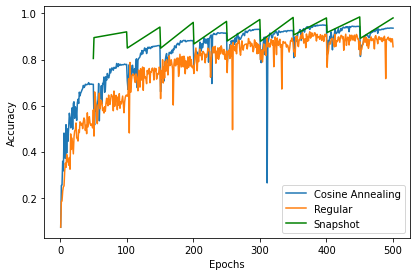

In [32]:
snapshot_x = []
snapshot_y = []
# Convert from tuple to two actual series
for i, y in enumerate(results):
    x_p = i + 1
    y, y_next = y
    snapshot_x.extend([x_p * 50, x_p * 50 + 1])
    snapshot_y.extend([y, y_next])

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.tight_layout()
sns.lineplot(data=res, dashes=False)
sns.lineplot(x=snapshot_x[:-1], y=snapshot_y[:-1], label='Snapshot', color='Green')
plt.savefig(f'../../results/{model_name}.pdf')